# Project Babylon

Purpose: create a tool that can synthesize a new name from any corpus.  Essentially, something that boils a corpus down to an essence (distribution of characters by position), then builds a word/name out of it.  

I have no idea if it'll produce anything interesting, but this is the solution to how boring my current monster name generator is (e.g. I saw the name "Drog" happen a few roles after seeing it once and it can't produce the name 'Grimace', which was a monster I drew/named)

In [29]:
# load modules and set params
import pandas as pd
import numpy as np
from string import ascii_lowercase
import random
from IPython.display import Image

random.seed(8675309)

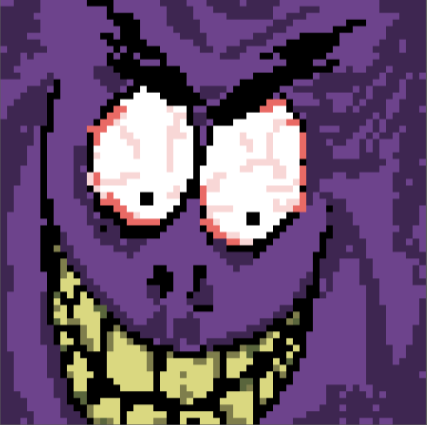

In [35]:
# Display image of 'Grimace'
Image(filename = "../assets/grimace.png", width=400, height=400)

For context, the image above is the pixel art that inspired this project.

I'm curious to see how many permutations there are if all 26 characters were possible for a word that is n-characters long:

In [2]:
n = 10
for i in range(n):
    print(26**i)

1
26
676
17576
456976
11881376
308915776
8031810176
208827064576
5429503678976


Of course, many of those permutations won't be possible because they won't occur in the corpus.  For instance, a corpus might not have a 'z' as the second character or a 'q' as the 10th.

Let's see what kind of permutations are possible if we pick 5 letters at random.  We should expect a garble of nonsense that doesn't even resemble something we can pronounce. 

In [3]:
letters = ''.join([random.choice(ascii_lowercase) for _ in range(5)])

In [4]:
for i in range(10):
    letters = ''.join([random.choice(ascii_lowercase) for _ in range(5)])
    print(letters)

iuuvh
uwlca
pukpb
hltwl
egimh
hxryt
iueof
rckzq
baxhg
trpzm


Gibberish.  However, if we choose each character by its likelihood in any position as well as with a weight for coming after the preceding character ('h' being more common after 't' and 's'), then we can hope to build words that seem to make sense.  Still, hard rules could be set where two constonant must have a vowel after unless those two exact preceeding characters occur in the corpus in a row. Something like that anway.  We'd want to have levers on the degrees of being one way or the other and test it out to get the frequencies right.

You could even have it take another input aside from a corpus: sentiment.  So a user could type 'harry potter' and select 'negative sentiment' (or maybe 'magical' or 'creature' or 'female'?), but I'm getting ahead of myself.

***
#### Get A Data Placeholder
Eventually, we'll want to be able to point this at any corpus trim the stopwords, and do all the usual NLP stuff, but since I just want to see if this project will create anything interesting, I'm going to load in some test data.  In my Fortitude Monster Namer, I generated 10,000 monster names and put them into a .csv

In [5]:
monster_names_raw = pd.read_csv("../data_raw/monster_names.csv")

In [6]:
monster_names_raw

,monster_names
0,Krodraz
1,Ixroz
2,Gharthor
3,Zlolibax
4,Gab
...,...
9995,Rathnor
9996,Grixeneva
9997,Ja'rouoy
9998,Nephnelldra


Let's convert to lowercase

In [7]:
monster_names = pd.DataFrame({"monster_names": monster_names_raw.monster_names.str.lower()})

In [8]:
monster_names.head()

,monster_names
0,krodraz
1,ixroz
2,gharthor
3,zlolibax
4,gab


Lets create a dataframe of letters (and "'") in the first column and each column to the right as the first character, the n+1 character, etc.

In [9]:
# build series of letters
letters = []

In [10]:
for i in range(len(ascii_lowercase)):
    letters.append(ascii_lowercase[i])

In [11]:
# add apostrophy
letters.append("\'")

In [12]:
print(letters)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"]


In [13]:
# get max character count to determine how many columns should exist
max_char = max(monster_names.monster_names.str.len())

In [14]:
# create column names that concatenate 'position' with the 1-max_char
col_names = []
for i in range(max_char):
    col_name = "pos" + str(i+1)
    if len(str(i+1))==1:
        col_name = "pos0" + str(i+1) # provide a leading 0 to 1-9
    col_names.append(col_name)

In [15]:
col_names

['pos01',
 'pos02',
 'pos03',
 'pos04',
 'pos05',
 'pos06',
 'pos07',
 'pos08',
 'pos09',
 'pos10',
 'pos11',
 'pos12',
 'pos13']

In [16]:
# build dataframe
char_counts = pd.DataFrame(index = letters, columns = col_names)

In [17]:
char_counts.head()

,pos01,pos02,pos03,pos04,pos05,pos06,pos07,pos08,pos09,pos10,pos11,pos12,pos13
a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# fill with 0s instead of NaN
char_counts = char_counts.fillna(0)
char_counts.head()

,pos01,pos02,pos03,pos04,pos05,pos06,pos07,pos08,pos09,pos10,pos11,pos12,pos13
a,0,0,0,0,0,0,0,0,0,0,0,0,0
b,0,0,0,0,0,0,0,0,0,0,0,0,0
c,0,0,0,0,0,0,0,0,0,0,0,0,0
d,0,0,0,0,0,0,0,0,0,0,0,0,0
e,0,0,0,0,0,0,0,0,0,0,0,0,0


Great, so now we have an empty dataframe ready to get filled with character counts before converting to probabilities

In [19]:
# we'll want to vectorize this for speed if it works, but for now, let's just loop through and get a count
for i in range(char_counts.shape[1]):
    # subset to the ith character in a series
    ith_char = monster_names.monster_names.str[i]
    # get count of character per character
    for j in range(len(letters)):
        char_counts.iloc[j,i] = sum(ith_char.dropna().str.count(char_counts.index[j]))
    

In [20]:
char_counts

,pos01,pos02,pos03,pos04,pos05,pos06,pos07,pos08,pos09,pos10,pos11,pos12,pos13
a,675,2496,1021,622,1305,992,583,526,421,215,69,12,1
b,780,149,286,279,143,95,87,64,29,9,1,1,0
c,358,132,118,245,140,145,121,135,146,69,27,2,0
d,776,40,551,599,386,286,329,196,124,81,28,7,1
e,354,941,767,398,748,550,382,321,281,174,59,18,4
f,241,50,17,126,37,90,81,38,16,11,5,1,0
g,1189,82,582,509,301,233,219,129,114,59,28,6,1
h,349,635,198,599,482,339,227,190,122,110,71,24,2
i,191,539,274,445,555,413,346,302,182,66,19,3,0
j,249,41,85,30,17,28,25,16,4,8,1,0,0


Absolutely gorgeous.  Now we need to convert to probabilities

In [21]:
# again, better to vectorize, but my tiny pea-brain (and lack of immediately know which functions to call in python)
# is capable of quickly doing a loop
char_probs = char_counts #CAUTION: you really should maybe use the clone module? you'll write over char_counts like this

for i in range(char_probs.shape[1]):
    column_sum = sum(char_probs.iloc[:,i])
    for j in range(char_probs.shape[0]):
        char_probs.iloc[j,i] = char_probs.iloc[j,i]/column_sum

In [22]:
# confirm a column sums to 1
sum(char_probs.iloc[:,i])

1.0

In [23]:
char_probs

,pos01,pos02,pos03,pos04,pos05,pos06,pos07,pos08,pos09,pos10,pos11,pos12,pos13
a,0.0675,0.249775,0.103781,0.067543,0.149262,0.124047,0.094566,0.112345,0.121361,0.107178,0.091391,0.066667,0.047619
b,0.0780,0.014910,0.029071,0.030296,0.016356,0.011879,0.014112,0.013669,0.008360,0.004487,0.001325,0.005556,0.000000
c,0.0358,0.013209,0.011994,0.026604,0.016013,0.018132,0.019627,0.028834,0.042087,0.034397,0.035762,0.011111,0.000000
d,0.0776,0.004003,0.056007,0.065045,0.044150,0.035763,0.053366,0.041862,0.035745,0.040379,0.037086,0.038889,0.047619
e,0.0354,0.094166,0.077963,0.043219,0.085554,0.068776,0.061963,0.068560,0.081003,0.086740,0.078146,0.100000,0.190476
f,0.0241,0.005004,0.001728,0.013682,0.004232,0.011254,0.013139,0.008116,0.004612,0.005484,0.006623,0.005556,0.000000
g,0.1189,0.008206,0.059158,0.055272,0.034428,0.029136,0.035523,0.027552,0.032862,0.029412,0.037086,0.033333,0.047619
h,0.0349,0.063544,0.020126,0.065045,0.055130,0.042391,0.036821,0.040581,0.035169,0.054835,0.094040,0.133333,0.095238
i,0.0191,0.053938,0.027851,0.048322,0.063479,0.051644,0.056123,0.064502,0.052465,0.032901,0.025166,0.016667,0.000000
j,0.0249,0.004103,0.008640,0.003258,0.001944,0.003501,0.004055,0.003417,0.001153,0.003988,0.001325,0.000000,0.000000


In [24]:
# probability of rolling 'grimace' if you have a 7 character string:
1/(char_probs.pos01['g']*char_probs.pos01['r']*char_probs.pos01['i']*char_probs.pos01['m']*char_probs.pos01['a']*\
    char_probs.pos01['c']*char_probs.pos01['e'])

1821936437.3653061

So basically, if you select a 7-character string, there is a 1 in 1.82 billion chance of getting 'grimace'. Neat.

At this point, we can see what a 'dumb' version of the monster namer would generate by arbitrarily picking a number of characters for a new word and then selecting letters based on the char_probs distributions

In [25]:
# random.choices allows a random selection based on weighted probabilities
random.choices(letters,char_probs.pos01)

['c']

In [26]:
# testing out a 7 character string
new_word_chars = 7

In [27]:
new_word = ''.join([random.choices(letters,char_probs.iloc[:,i])[0] for i in range(new_word_chars)])

In [28]:
for i in range(20):
    print(''.join([random.choices(letters,char_probs.iloc[:,i])[0] for i in range(new_word_chars)]))

jeotorc
duiuaav
sargche
kaxboee
rnuieof
sakktla
marouca
kbbtehi
gaiunst
kedrgel
vzclggg
uasenur
errclda
bibaido
dcenanb
leldaai
ularelf
aaeodlu
frafbsa
dmesogo


Still nonsense, as expected.  What we'll want is to manipulate the probabilities based on preceding characters via conditional probability.  I'm imagining something where the second character's per-letter probabilities are a weighted mix of the probabilties of that character being in the second position as well as the conditional probability of that character following the preceding one (regardless of position).  It seems intuitive that we'd want to perhaps do this sort of weighting out to 2-3 characters with a strong probabalistic bias toward the continuity of characters in a sequence over position.  This is where I'd want to have a weight that we can treat as a variable and test results with various weights.  

Still, lots of building to do to get us there.  Seems like we'll want a function which takes the current in-process string and look-back number of characters then outputs the probabilities of each letter given those parameters.  So basically, if the string I'm building has 'Moo', and I want 1 character worth of lookback, it'll look at all instances of 'o' in the corpus and provide the probability of each letter following 'o'.  If I then want 2 characters worth of lookback, then it'd look at all instances of 'oo' in the corpus and return the probabilities of each letter following 'oo'.  Obviously, more weight should be placed on the 'oo' since we don't want a high likelihood of 'ooo' and 'o' is probably pretty likely to follow a single 'o'.  

***
Thinking on this days later, perhaps a large static lookup that is 27^3 long for all combinations of `letters` for 3 characters (recall that `letters` is a-z plus an apostrophe for the 27th character).  Then, the 4th column would be the count of those combinations found in the corpus.  This could then be transformed to give the probabilities of the 2nd and 3rd character based on the 1st or 1st and 2nd characters.  Perhaps an illustration would be more informative:

In [38]:
# create data for first column by simply repeating letters 27^2 times
col1_data = letters*27*27

In [40]:
len(col1_data)

19683

In [49]:
# create data for 2nd column by repeating 'a' 27 times, 'b' 27 times, etc. then repeating all that 27 times
col2_data = []
for i in range(len(letters)):
    col2_data_addition = [letters[i]]*len(letters)
    col2_data = col2_data + col2_data_addition

# now repeat this 27 times
col2_data = col2_data*27

In [50]:
# validate same length
len(col2_data)

19683

In [54]:
# create data for 3rd column by repeating 'a' 27 ^2 times, 'b' 27^2 times, etc
col3_data = []
for i in range(len(letters)):
    col3_data_addition = [letters[i]]*len(letters)*len(letters)
    col3_data = col3_data + col3_data_addition

In [56]:
# validate same length
len(col3_data)

19683

In [94]:
char_seq_counts = pd.DataFrame({"char1": col1_data, "char2": col2_data, "char3": col3_data, "freq": 0})

In [95]:
char_seq_counts

,char1,char2,char3,freq
0,a,a,a,0
1,b,a,a,0
2,c,a,a,0
3,d,a,a,0
4,e,a,a,0
...,...,...,...,...
19678,w,',',0
19679,x,',',0
19680,y,',',0
19681,z,',',0


So now we have every combination of a-z+' for 3 characters! Time to get a count of each sequence appearing in the data.  There's probably a better way, but if I convert every monster name into on continuous string separated by commas (to avoid the one name blending into another as in 'krodraz' then 'ixroz' returning 1 count of 'azi' and 'zix' (the letters between)), then I should be able to get all the unique counts

In [83]:
monster_names_string = ""
for i in range(monster_names.shape[0]):
    monster_addition = monster_names.monster_names[i]
    monster_names_string = monster_names_string + "," + monster_addition

In [84]:
monster_names_string

",krodraz,ixroz,gharthor,zlolibax,gab,kythsis,byr,thraxqua,gohgraare,dackeeg,ixdron,krondbernul,lhuridrid,schmeruuus,kujmararr,espka,hixil,tatzmorok,belroz,vanlogheel,top,gnarratto,gohdan,ugtus,gnarhda,umblen,drogska,golgaare,malatar,iztunlem,qarulft,van,benta,bel,mopapov,amprax,gakul,bel,onsekyte,rahgrenlaw,augnertria,grokrod,mephhda,ibqua,gaghanik,brighach,xanan,lhuryadetra,ghokopa,rakged,uzrupfang,spasatt,kjelelkiac,gohtarosk,doghchuqdorf,dakdeg,eldalf,hassurkbej,aratiknus,belthamra,thornik,daril,max,krarmorare,jekroja,valalfryn,graxiac,bulryn,saureldt,korged,hixvatesk,valeldt,dagus,mosh,yngda,mezjanbaq,caoquaok,rodnell,novde,jesel,ekgoyjab,graxiel,kaerojpu,garroan,cynoch,lhurruppov,aesstaf,rakkan,sephgodorekt,onnok,salrot,qo',gnarluvnos,kaeaeayte,ev,gnaretra,grungar,thritaa,bogorva,kjel,raklaw,bul,dakmach,hixhambogh,agahtog,meztaryte,rakunx,krenkalfsker,kilnthamnock,caohanite,crodoh,morgoy,leoitz,majtac,doghturach,drazbe',yakya,ungei,dratun,drootanock,aboborska,sephdron,mzugititz,g

In [85]:
# testing to see how often the string of the first 3 letters appears
monster_names_string.count("kro")

189

In [86]:
# testing how often the full first monster name appears
monster_names_string.count("krodraz")

1

In [96]:
# loop through every 3-letter combination and get a count of each one
for i in range(char_seq_counts.shape[0]):
    string = char_seq_counts.char1[i] + char_seq_counts.char2[i] + char_seq_counts.char3[i]
    char_seq_counts.freq[i] = monster_names_string.count(string)

/Users/willwright/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [97]:
char_seq_counts

,char1,char2,char3,freq
0,a,a,a,6
1,b,a,a,44
2,c,a,a,1
3,d,a,a,3
4,e,a,a,4
...,...,...,...,...
19678,w,',',0
19679,x,',',0
19680,y,',',0
19681,z,',',0


Fantastic! Now, we have a frequency count of every 3-character string within the corpus.  It may be the case that we'll want to come back and add some rules to this where we do something like remove certain combinations such as 'aaa', 'iii', 'zzz', and others that follow a pattern like '3 vowels/constonants in a row' (with exceptions for some such as 'iou' as in 'parsimonious').  For now, however, we just want to get a proof of concept.

Next, we can create a function which accepts 1-2 characters and return a conditional probability dataframe for the next character. If we have 1 character as input (in the case of having only selected the first character), then what we'll want to do is take this 3-character dataframe and group on the 1st character, then summarize the count.  This will reduce the dimensions to 2 and remove the 3rd character consideration.  If we have 2 characters as input, then we can use the table as-is and simply filter to the correct characters. Ultimately, the goal is to create a table like `char_probs` which gives us a conditional probability of `letters` based on either one or two character inputs.

In [125]:
def cond_char_prob(string):
    chars = len(string)
    if chars==1:
        char_seq_counts_lookup = char_seq_counts[char_seq_counts.char1==string[0]]\
            .groupby('char2')['freq'].agg(['sum'])
    if chars==2:
        char_seq_counts_lookup = char_seq_counts[(char_seq_counts.char1==string[0]) & (char_seq_counts.char2==string[1])]
    return(char_seq_counts_lookup)

In [130]:
cond_char_prob('sh')

,char1,char2,char3,freq
207,s,h,a,49
936,s,h,b,5
1665,s,h,c,2
2394,s,h,d,6
3123,s,h,e,2
3852,s,h,f,2
4581,s,h,g,2
5310,s,h,h,3
6039,s,h,i,41
6768,s,h,j,1
